In [5]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [6]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


In [7]:
# Read in a image from torchvision
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


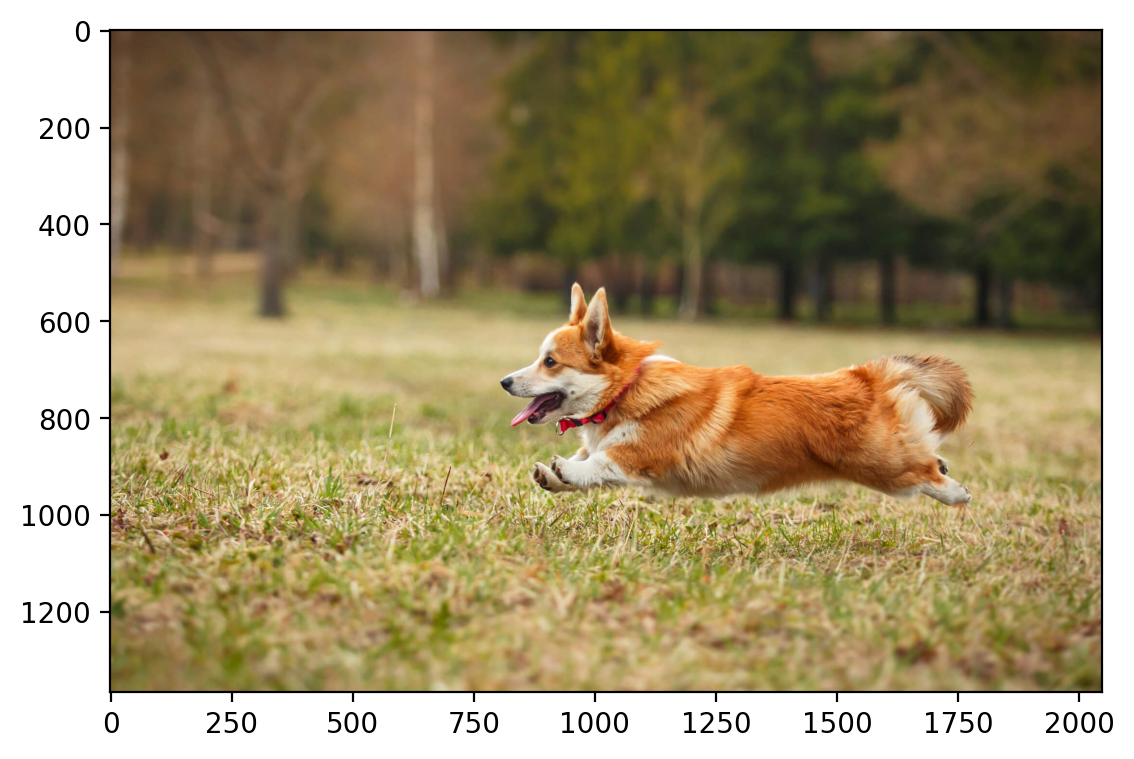

In [8]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [9]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [10]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [11]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [12]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 600, 800, 300, 300)
crop = crop.to(device)

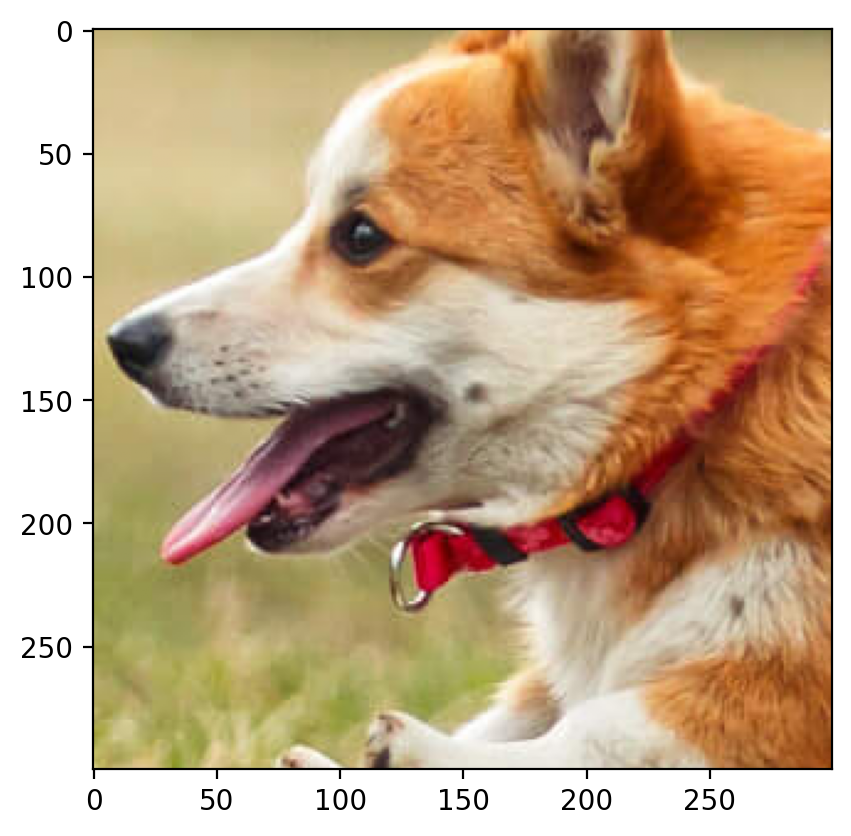

In [13]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

In [14]:
crop = crop.to(device)

# **Q1**

In [15]:
def matrix_factorization(A,r,E):

  A=A.to(device)

  np.random.seed(42)
  W=torch.randn(A.shape[0],r,requires_grad=True).to(device)
  H=torch.randn(r,A.shape[1],requires_grad=True).to(device)

  optimizer=torch.optim.Adam([W,H],lr=0.01)

  mask = ~torch.isnan(A)

  for e in range(E):
    matr_diff=A-torch.mm(W,H)
    diff_vector=matr_diff[mask]
    loss=torch.norm(diff_vector)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return W,H,loss.item()

In [16]:
rank=50

reconstr_img=torch.Tensor(crop.shape)
W_R,H_R,loss_R=matrix_factorization(crop[0],rank,1000)
W_G,H_G,loss_G=matrix_factorization(crop[1],rank,1000)
W_B,H_B,loss_B=matrix_factorization(crop[2],rank,1000)

with torch.no_grad():
  reconstr_img_R=torch.mm(W_R,H_R)
  reconstr_img_G=torch.mm(W_G,H_G)
  reconstr_img_B=torch.mm(W_B,H_B)

  reconstr_img=torch.stack([reconstr_img_R,reconstr_img_G,reconstr_img_B],axis=-1)
  reconstr_img=rearrange(reconstr_img,'h w c -> c h w')

In [17]:
def plot_images(orig_img,reconstr_img):
  fig=plt.figure(figsize=(12,10))
  gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])
  ax1=fig.add_subplot(gs[0])
  ax1.imshow(rearrange(orig_img, 'c h w -> h w c').cpu().numpy())
  ax1.set_title('Original Image')
  ax2=fig.add_subplot(gs[1])
  ax2.imshow(rearrange(reconstr_img, 'c h w -> h w c').cpu().numpy())
  ax2.set_title('Reconstructed Image')
  plt.show()


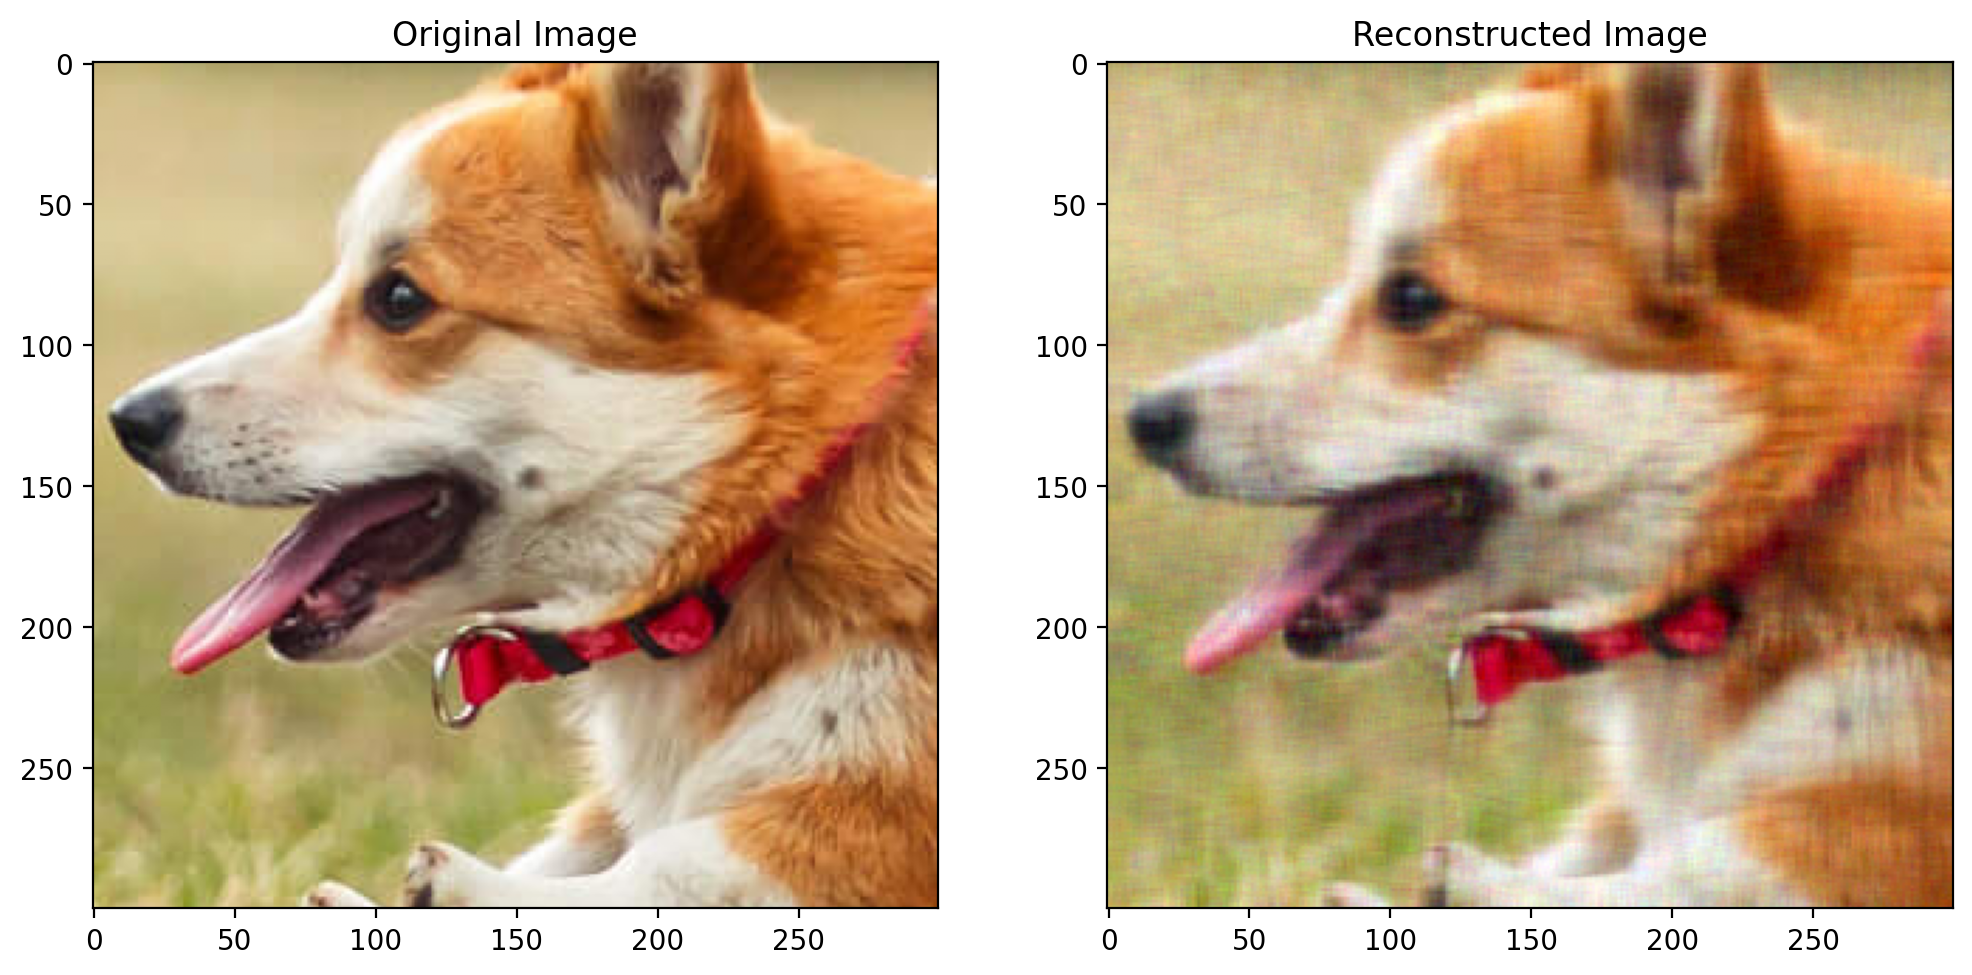

In [18]:
plot_images(crop,reconstr_img)


In [19]:
def get_rmse(orig_img,reconstr_img):
  return torch.sqrt(torch.mean((orig_img-reconstr_img)**2))

def get_psnr(orig_img,reconstr_img):
  return 20*torch.log10(1/get_rmse(orig_img,reconstr_img))

In [20]:
print("RMSE : ",get_rmse(crop,reconstr_img).item(),"\nPSNR : ",get_psnr(crop,reconstr_img).item())

RMSE :  0.04183272804624812 
PSNR :  27.569676255220003


# **Q2**

### **Through Linear Regression and RFF**

In [21]:
def mask_image(image, n):
  copy_img=image.clone()
  mask = np.ones(image[0].shape, dtype=bool)
  num_pixels = np.prod(image[0].shape)
  missing_indices = np.random.choice(num_pixels, n, replace=False)
  mask.ravel()[missing_indices] = False
  for channel in range(image.shape[0]):
    copy_img[channel][~mask]=torch.nan
  return copy_img,mask

torch.Size([3, 300, 300])


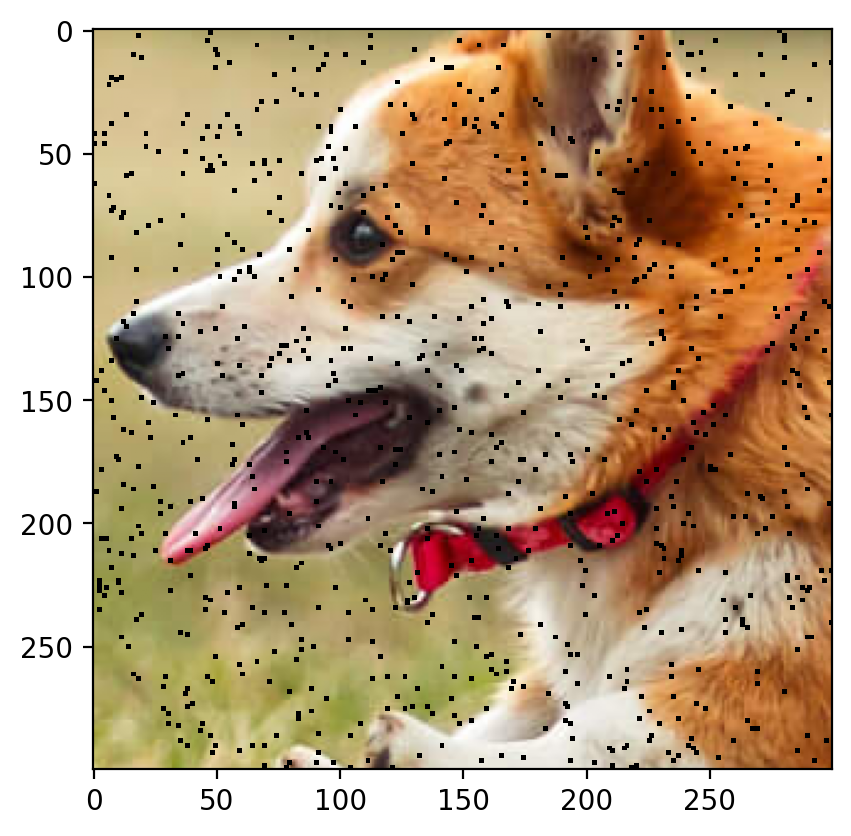

In [22]:
masked_img,mask=mask_image(crop,900)

plt.imshow(rearrange(masked_img, 'c h w -> h w c').cpu().numpy())
print(masked_img.shape)

In [23]:
def create_coordinate_map(img):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width=img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(width).repeat(height, 1)
    h_coords = torch.arange(height).repeat(width, 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [24]:
X, y = create_coordinate_map(crop)
X.shape, y.shape

(torch.Size([90000, 2]), torch.Size([90000, 3]))

In [25]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [26]:
mask=mask.flatten()
X_train=X[mask]
y_train=y[mask]

In [27]:
from sklearn.preprocessing import MinMaxScaler
scaler_X = MinMaxScaler(feature_range=(-1, 1)).fit(X_train.cpu())

X_train = scaler_X.transform(X_train.cpu())

X_train = torch.tensor(X_train).to(device)

X_train = X_train.float()

print(X_train, X_train.shape)

tensor([[-1.0000, -1.0000],
        [-1.0000, -0.9933],
        [-1.0000, -0.9866],
        ...,
        [ 1.0000,  0.9866],
        [ 1.0000,  0.9933],
        [ 1.0000,  1.0000]]) torch.Size([89100, 2])


In [28]:
num_features=40000
sigma=0.008
from sklearn.kernel_approximation import RBFSampler
rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2), random_state=42)
X_train_rff = rff.fit_transform(X_train.cpu().numpy())
X_train_rff=torch.tensor(X_train_rff, dtype=torch.float32).to(device)

In [29]:
print(X_train_rff.shape,y_train.shape)

torch.Size([89100, 40000]) torch.Size([89100, 3])


In [30]:
lin_model = LinearModel(X_train_rff.shape[1], 3)
lin_model.to(device)

train(lin_model, 0.005, X_train_rff, y_train, 1000)

Epoch 0 loss: 0.369920
Epoch 100 loss: 0.046227
Epoch 200 loss: 0.010636
Epoch 300 loss: 0.005702
Epoch 400 loss: 0.003556
Epoch 500 loss: 0.002268
Epoch 600 loss: 0.001470
Epoch 700 loss: 0.000973
Epoch 800 loss: 0.000665
Epoch 900 loss: 0.000476


0.0003614860470406711

In [31]:
# X_test,_=create_coordinate_map(crop)
X_test_scaled = torch.tensor(scaler_X.transform(X.cpu())).float().to(device)
X_test_rff=torch.tensor(rff.transform(X_test_scaled))
with torch.no_grad():
    y_pred = lin_model(X_test_rff)

In [32]:
# plt.imshow(rearrange(pred_img, 'c h w -> h w c').cpu().numpy())
print(y_pred.shape)

torch.Size([90000, 3])


In [33]:
n,h,w=masked_img.shape
pred_img=y_pred.reshape(h,w,n)
pred_img=pred_img.permute(2,0,1)

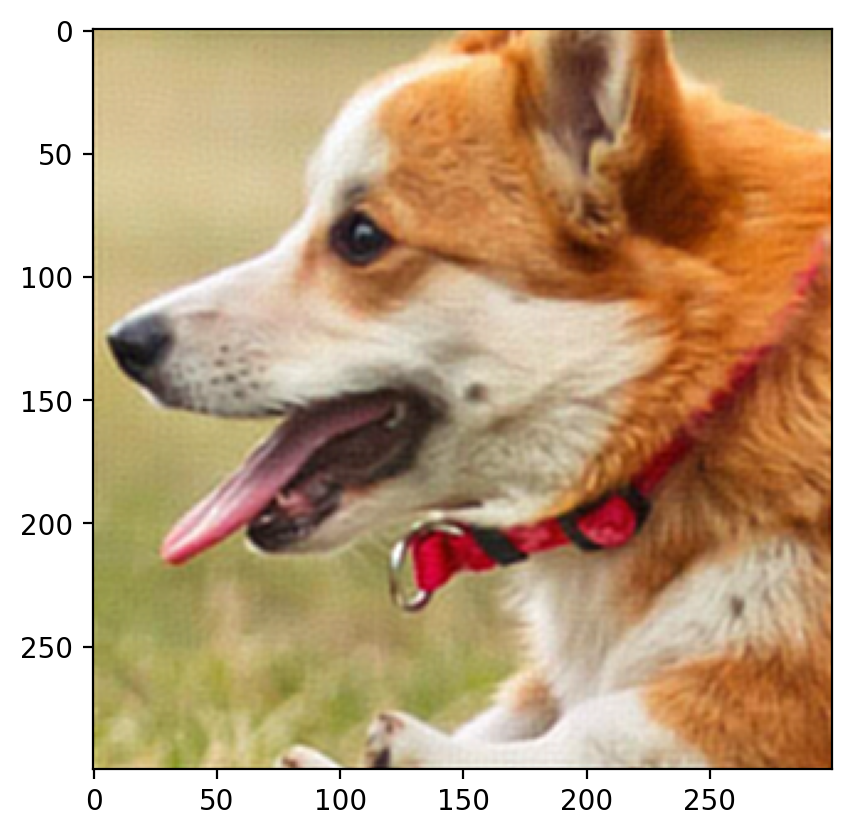

In [34]:
plt.imshow(rearrange(pred_img,'c h w -> h w c').numpy())

In [35]:
print("RMSE : ",get_rmse(crop,pred_img).item(),"\nPSNR : ",get_psnr(crop,pred_img).item())

RMSE :  0.019077462111385918 
PSNR :  34.38958800598246


### **Through Matrix Factorization**

In [36]:
rank=50

reconstr_img=torch.Tensor(crop.shape)
W_R,H_R,loss_R=matrix_factorization(masked_img[0],rank,1000)
W_G,H_G,loss_G=matrix_factorization(masked_img[1],rank,1000)
W_B,H_B,loss_B=matrix_factorization(masked_img[2],rank,1000)

with torch.no_grad():
  reconstr_img_R=torch.mm(W_R,H_R)
  reconstr_img_G=torch.mm(W_G,H_G)
  reconstr_img_B=torch.mm(W_B,H_B)

  rec_img=torch.stack([reconstr_img_R,reconstr_img_G,reconstr_img_B],axis=-1)
  rec_img=rearrange(rec_img,'h w c -> c h w')

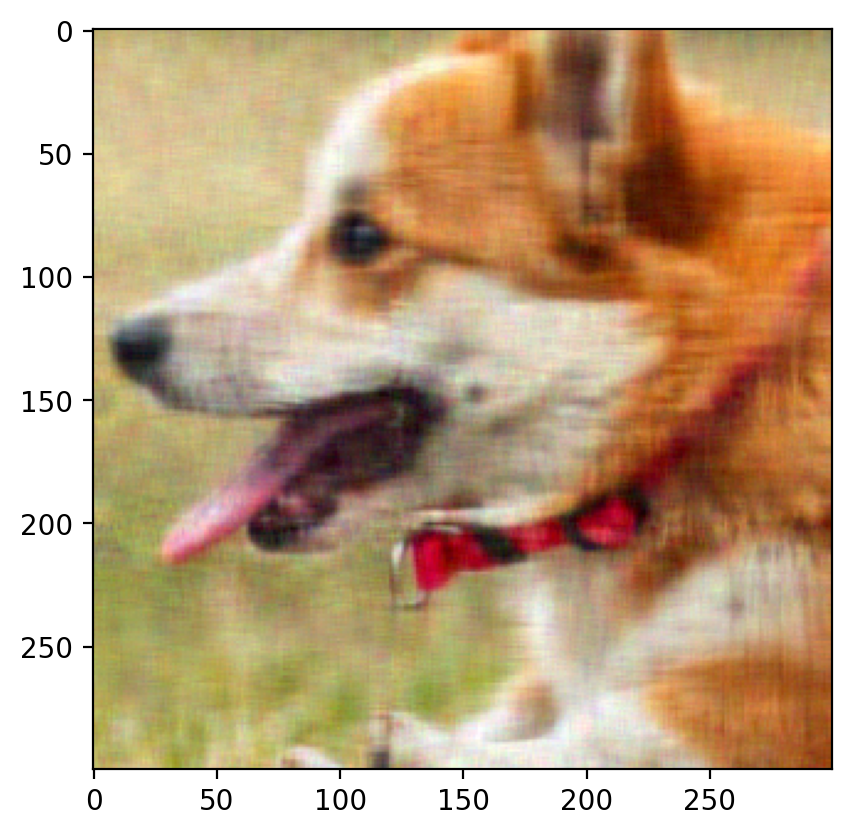

In [37]:
plt.imshow(rearrange(rec_img,'c h w -> h w c').numpy())

In [38]:
print("RMSE : ",get_rmse(crop,rec_img).item(),"\nPSNR : ",get_psnr(crop,rec_img).item())

RMSE :  0.04202984048184023 
PSNR :  27.52884516586224


####**We see that the results from Matrix Factorization are of poorer quality compared to linear regression using RFF. This is because Matrix Factorization tends to produce blurry or over-smoothed results because it tries to approximate the image with a low-rank matrix. This method is more suited for simple, low-detail images.Linear regression with RFF can capture more complex patterns and textures, leading to sharper and more accurate reconstructions.**